In [1]:
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(fitdistrplus)
library(bda)
library(arules)

Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

This is bayesplot version 1.5.0
- Plotting theme set to bayesplot::theme_default()
- Online documentation at mc-stan.org/bayesplot
Loading required package: MASS
Loading required package: survival

At

In [2]:
data_path <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
table_path <- "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

In [3]:
get_data <- function(data_path, file_name){
    data <- read.table(file.path(data_path, file_name), header = TRUE, sep = "\t")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])  
    data[, 'task'] <- factor(data[, 'task'])  
    data[, 'session'] <- factor(data[, 'session'])  
    data$AUC <- 1 - data$k

    return(data)
}

In [4]:
get_bf_k <- function(data, var, family, rscale, n=1){   
    # sd(var) in this case is 0.5, as var is task (equal number of 0's and 1's)
    priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class='Intercept'),
                    set_prior(sprintf('cauchy(0.0, %f)', rscale*sd(data[, var])/0.5), class='b'))

    formula_null <- as.formula(paste(var, "~ (1 | subj_id)"))
    formula_task <- as.formula(paste(var, "~ (1 | subj_id) + task"))
    formula_session <- as.formula(paste(var, "~ (1 | subj_id) + session"))
    formula_inter <- as.formula(paste(var, "~ (1 | subj_id) + task*session"))

    m_null <- brm(formula_null, data=data, family=family, save_all_pars=TRUE, prior=priors_task[1,],
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    m_task <- brm(formula_task, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))    
    m_session <- brm(formula_session, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    m_inter <- brm(formula_inter, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    
    bfs <- data.frame(double(), double(), double())
    
    for (i in 1:n) {
        bf <- t(c(bayes_factor(x1=m_task, x2=m_null, silent=TRUE)$bf, 
                  bayes_factor(x1=m_session, x2=m_null, silent=TRUE)$bf, 
                  bayes_factor(x1=m_inter, x2=m_null, silent=TRUE)$bf))

        bfs <- rbind(bfs, bf)
    }
    
    colnames(bfs) <- c('bf_task', 'bf_session', 'bf_inter')
    
    result = list(bf=colMeans(bfs),  
                  m_null=m_null, 
                  m_task=m_task, 
                  m_session=m_session,
                  m_inter=m_inter)
    
    return(result)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

show_result <- function(result) {
    print("Bayes factors: ")
    print(result$bf)
    hpd_task<-HPDinterval(as.mcmc(result$m_task, combine_chains = TRUE))
    hpd_session<-HPDinterval(as.mcmc(result$m_session, combine_chains = TRUE))
    print("Credible interval for the task effect (walking relative to mouse): ")
    print(hpd_task['b_taskwalking',])
    print("Credible interval for the session effect (2nd session relative to 1st): ")
    print(hpd_session['b_sessionsecond',])
#     mcmc_areas_ridges(as.matrix(as.mcmc(result$m_bias, combine_chains = TRUE)), regex_pars = "b_task", prob=0.95)
}

# Preregistered analysis

In [5]:
data <- get_data(data_path, "k_values_54.csv")
print(nrow(data))

[1] 108


In [6]:
data

subj_id,task,k,session,sequence,SS_bias,AUC
1322,mouse,0.9325057,first,mw,-0.48821750,0.06749429
1402,mouse,0.9703482,first,mw,0.03046794,0.02965183
1408,mouse,0.3983733,second,wm,0.11081885,0.60162671
1474,mouse,0.8751284,first,mw,-0.04696042,0.12487158
1879,mouse,0.8239869,second,wm,-0.27269836,0.17601313
2045,mouse,0.7232734,first,mw,-0.50074000,0.27672660
2249,mouse,0.9584760,first,mw,-0.60422898,0.04152397
2261,mouse,0.8941924,first,mw,-0.57138308,0.10580765
2752,mouse,0.9527112,second,wm,0.14741077,0.04728881
2758,mouse,0.8964184,second,wm,-0.17682609,0.10358162


Contrary to what was assumed at the time of preregistration, k-values aren't approximated well by the normal distribution. Still, we check Bayes factors according to the originally specified design (`gaussian` family parameter in brms)

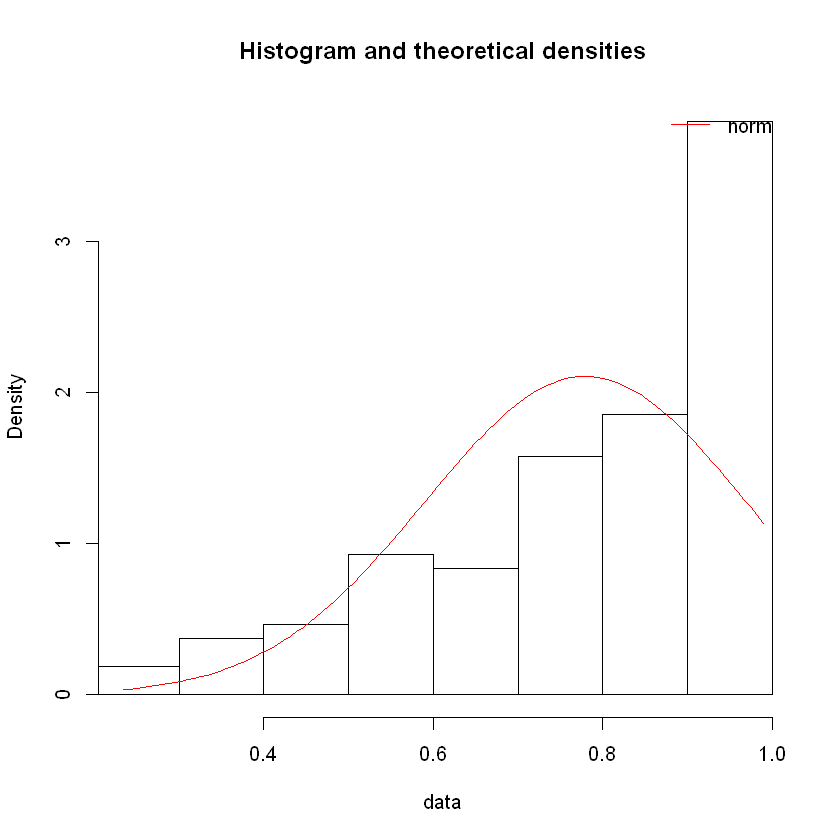

In [7]:
fit_w  <- fitdist(data$k, "norm")
denscomp(fit_w)

In [7]:
prereg_result <- get_bf_k(data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.394 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.536 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.355 seconds (Warm-up)
               0.144 seconds (Sampling)
               0.499 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.397 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.539 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.336 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.553 seconds (Warm-up)
               0.233 seconds (Sampling)
               0.786 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.448 seconds (Warm-up)
               0.194 seconds (Sampling)
               0.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.419 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.603 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.439 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.611 seconds (Warm-up)
               0.255 seconds (Sampling)
               0.866 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.685 seconds (Warm-up)
               0.27 seconds (Sampling)
               0.955 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.651 seconds (Warm-up)
               0.245 seconds (Sampling)
               0.896 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.564 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.741 seconds (Warm-up)
               0.294 seconds (Sampling)
               1.035 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.59 seconds (Warm-up)
               0.506 seconds (Sampling)
               1.096 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.722 seconds (Warm-up)
               0.448 seconds (Sampling)
               1.17 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.642 seconds (W

In [8]:
save_posterior(prereg_result$m_session, "posterior_k_session_prereg.csv")
save_posterior(prereg_result$m_task, "posterior_k_task_prereg.csv")

In [9]:
show_result(prereg_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
0.07325951 0.26364107 0.00508960 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05535697  0.02371344 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.069938140  0.004452962 


# Exploratory analysis

# Accounting for the observed distribution of $k$

After reaching BF>10 in favor of null model over the model with the main effect of task, we terminated data collection, even though BF of the model with the session effect has not yet reached the designated boundary of 10. The reason was that it became evident that there is no difference in discounting behavior between tasks.  Just in case, we checked that this holds if we change the `family` parameter of the brms regression to `weibull`, as Weibull distribution more closely matches the distribution of k-values (we ran the model on zero-peaked quantity `1-k`)

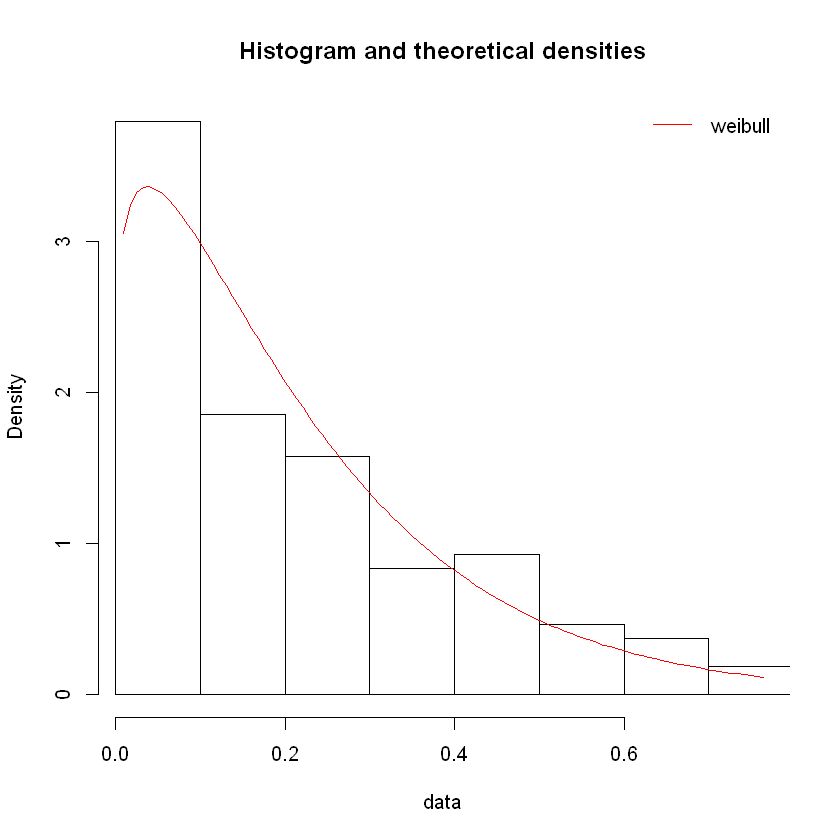

In [12]:
fit_w  <- fitdist(data$AUC, "weibull")
denscomp(fit_w)

In [10]:
AUC_weibull_result <- get_bf_k(data, 'AUC', weibull(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.191 seconds (Warm-up)
               2.522 seconds (Sampling)
               4.713 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.145 seconds (Warm-up)
               1.996 seconds (Sampling)
               4.141 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.191 seconds (Warm-up)
               2.059 seconds (Sampling)
               4.25 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.133 seconds (

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0.016 seconds
1000 transitions using 10 leapfrog steps per transition would take 160 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.077 seconds (Warm-up)
               2.707 seconds (Sampling)
               5.784 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.126 seconds (Warm-up)
               1.821 seconds (Sampling)
               3.947 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.283 seconds (Warm-up)
               2.641 seconds (Sampling)
               4.924 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.509 se

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.625 seconds (Warm-up)
               1.868 seconds (Sampling)
               4.493 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.407 seconds (Warm-up)
               2 seconds (Sampling)
               4.407 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.435 seconds (Warm-up)
               2.077 seconds (Sampling)
               4.512 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.396 seconds (War

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.608 seconds (Warm-up)
               2.204 seconds (Sampling)
               4.812 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.674 seconds (Warm-up)
               2.107 seconds (Sampling)
               4.781 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.465 seconds (Warm-up)
               1.998 seconds (Sampling)
               4.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.54 seco

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [11]:
show_result(AUC_weibull_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
 0.3296813  0.6722757  0.1412396 
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1258177  0.2234786 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.05510504  0.30254723 


The Bayes factors in favor of the null model decreased and became less conclusive. We however think that using a modified definition of k-value can help to further clarify whether the task or session afffected k. 

# Using log-delays in calculating k-values

Specifically, as many subjects are close to the head part of the k-value distribution (0.9 to 1.0), we might want to emphasize small differences in discounting curves for these subjects. We can do this by changing the definition of k-value in line with Killeen's additive utility model of delay discounting. Specifically, we use log-scaled delays when calculating k-values (which are recorded to \_log.csv files during preprocessing). 

In [12]:
log_delay_data <- get_data(data_path, "k_values_54_log.csv")
print(nrow(log_delay_data))

[1] 108


These k-values are more normally distributed

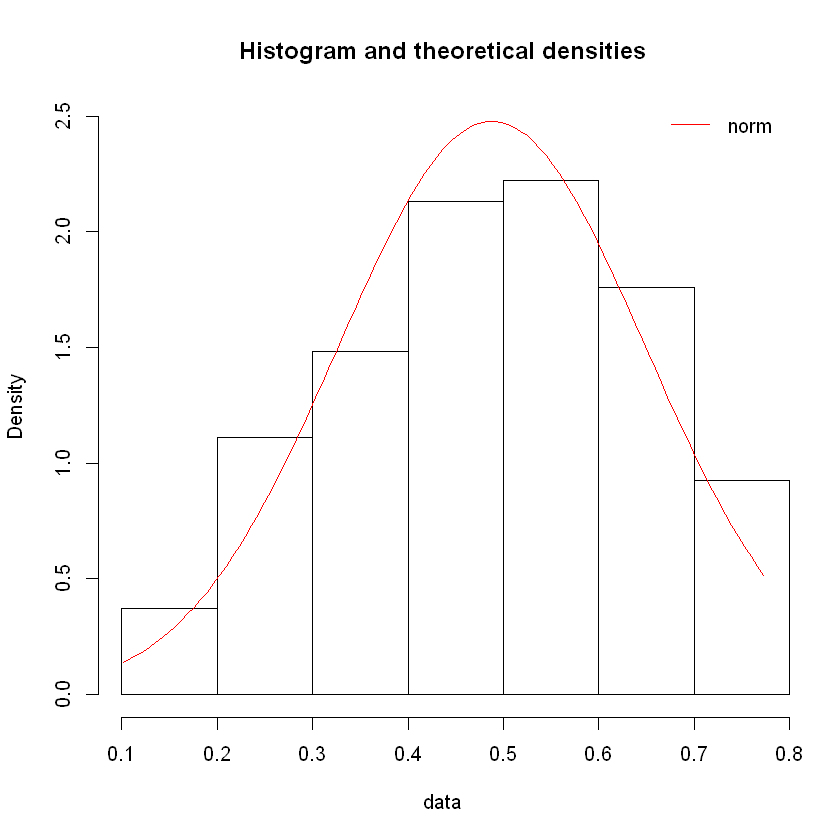

In [16]:
fit_w  <- fitdist(log_delay_data$k, "norm")
denscomp(fit_w)

In [13]:
log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.369 seconds (Warm-up)
               0.152 seconds (Sampling)
               0.521 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.413 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.555 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.395 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.537 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.362 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.504 seconds (Warm-up)
               0.205 seconds (Sampling)
               0.709 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.577 seconds (Warm-up)
               0.186 seconds (Sampling)
               0.763 seconds (Total)


Gradient evaluation took 0.002 seconds
1000 transitions using 10 leapfrog steps per transition would take 20 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.489 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.672 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.497 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.671 seconds (Warm-up)
               0.263 seconds (Sampling)
               0.934 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.839 seconds (Warm-up)
               0.433 seconds (Sampling)
               1.272 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.686 seconds (Warm-up)
               0.279 seconds (Sampling)
               0.965 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.612 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.589 seconds (Warm-up)
               0.202 seconds (Sampling)
               0.791 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.569 seconds (Warm-up)
               0.378 seconds (Sampling)
               0.947 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.686 seconds (Warm-up)
               0.32 seconds (Sampling)
               1.006 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.593 seconds (

In [14]:
save_posterior(log_delay_result$m_session, "posterior_k_session_log_delay.csv")
save_posterior(log_delay_result$m_task, "posterior_k_task_log_delay.csv")

In [15]:
show_result(log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session     bf_inter 
  0.07445368 245.13854455   4.28897401 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04325040  0.02016277 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09181698 -0.03447705 


# Saving results to a table

In [19]:
save_bf_table <- function(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name){
    hyp_2_format_string <- "\\begin{table}[!h]
                \\centering
                \\sisetup{round-mode=places, round-precision=1, scientific-notation=false}
                \\caption{%s}
                \\label{%s}
                \\begin{tabular}{@{}lll@{}}
                \\toprule
                dependent variable & $\\textrm{M}_{\\textrm{task}}$ & $\\textrm{M}_{\\textrm{session}}$ \\\\ \\midrule
                $k \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k \\sim ~ \\textrm{Weibull}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k_{\\log} \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & \\num{%g}\\\\ \\bottomrule
                \\end{tabular}
                \\end{table}"
    
    # we invert all BFs < 1 for clarity
    output <- sprintf(hyp_2_format_string, caption, label, 
                      1/prereg_result$bf[1], 1/prereg_result$bf[2], 
                      1/AUC_weibull_result$bf[1], 1/AUC_weibull_result$bf[2], 
                      1/log_delay_result$bf[1], log_delay_result$bf[2])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [20]:
caption = "Results of testing Hypothesis 2: Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf"
file_name = "hyp_2_bf.tex"

save_bf_table(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name)

# Checking the effect of rscale

In [21]:
get_all_results <- function(rscale, n=1){
    prereg_result <- get_bf_k(data, 'k', gaussian(), rscale, n)
    AUC_weibull_result <- get_bf_k(data, 'k', weibull(), rscale, n)
    log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), rscale, n)
    
    result = list(prereg_result=prereg_result,  
                  AUC_weibull_result=AUC_weibull_result, 
                  log_delay_result=log_delay_result)
    
    return(result)
}

### Narrower priors (rscale = 0.5)

In [22]:
narrow_prior_results <- get_all_results(rscale = 0.5, n = 10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.485 seconds (Warm-up)
               0.201 seconds (Sampling)
               0.686 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.388 seconds (Warm-up)
               0.152 seconds (Sampling)
               0.54 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.378 seconds (Warm-up)
               0.185 seconds (Sampling)
               0.563 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.409 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.462 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.644 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.467 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.651 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.442 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.625 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.414 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.472 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.431 seconds (Warm-up)
               0.174 seconds (Sampling)
               0.605 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.426 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.618 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.452 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.493 seconds (Warm-up)
               0.232 seconds (Sampling)
               0.725 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.539 seconds (Warm-up)
               0.224 seconds (Sampling)
               0.763 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.587 seconds (Warm-up)
               0.236 seconds (Sampling)
               0.823 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.525 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.746 seconds (Warm-up)
               1.982 seconds (Sampling)
               5.728 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.171 seconds (Warm-up)
               2.452 seconds (Sampling)
               5.623 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.465 seconds (Warm-up)
               2.142 seconds (Sampling)
               4.607 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.838 seconds 

Warning message:
"There were 5 divergent transitions after warmup. Increasing adapt_delta above 0.9 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.026 seconds (Warm-up)
               1.397 seconds (Sampling)
               4.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.967 seconds (Warm-up)
               1.797 seconds (Sampling)
               4.764 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.646 seconds (Warm-up)
               1.584 seconds (Sampling)
               4.23 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.526 seconds (

Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.001 seconds (Warm-up)
               1.263 seconds (Sampling)
               4.264 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.555 seconds (Warm-up)
               1.444 seconds (Sampling)
               3.999 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.584 seconds (Warm-up)
               1.069 seconds (Sampling)
               3.653 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.757 seconds 

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.865 seconds (Warm-up)
               1.79 seconds (Sampling)
               4.655 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.98 seconds (Warm-up)
               1.809 seconds (Sampling)
               5.789 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.354 seconds (Warm-up)
               1.454 seconds (Sampling)
               3.808 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.152 seconds (W

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.378 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.511 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.404 seconds (Warm-up)
               0.131 seconds (Sampling)
               0.535 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.393 seconds (Warm-up)
               0.132 seconds (Sampling)
               0.525 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.385 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.462 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.654 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.479 seconds (Warm-up)
               0.177 seconds (Sampling)
               0.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.487 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.669 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.508 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.454 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.636 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.476 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.497 seconds (Warm-up)
               0.287 seconds (Sampling)
               0.784 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.569 seconds (Warm-up)
               0.27 seconds (Sampling)
               0.839 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.596 seconds (Warm-up)
               0.356 seconds (Sampling)
               0.952 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.612 seconds (Warm-up)
               0.302 seconds (Sampling)
               0.914 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.627 seconds (

In [23]:
show_result(narrow_prior_results$prereg_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
0.10755538 0.34950305 0.01207833 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05382311  0.02611413 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.07209215  0.00104024 


In [24]:
show_result(narrow_prior_results$AUC_weibull_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.140410004 0.224841124 0.009854557 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.07248879  0.03275157 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.07975400  0.02421593 


In [25]:
show_result(narrow_prior_results$log_delay_result)

[1] "Bayes factors: "
   bf_task bf_session   bf_inter 
  0.101559 306.796869   9.875049 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04490213  0.01909830 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.08856829 -0.03340790 


### Wider priors

In [26]:
wide_prior_results <- get_all_results(rscale = 1.0, n = 10)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.341 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.474 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.327 seconds (Warm-up)
               0.142 seconds (Sampling)
               0.469 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.297 seconds (Warm-up)
               0.133 seconds (Sampling)
               0.43 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.327 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.424 seconds (Warm-up)
               0.189 seconds (Sampling)
               0.613 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.465 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.406 seconds (Warm-up)
               0.192 seconds (Sampling)
               0.598 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.412 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.438 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.62 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.454 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.636 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.391 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.573 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.424 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.519 seconds (Warm-up)
               0.354 seconds (Sampling)
               0.873 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.54 seconds (Warm-up)
               0.376 seconds (Sampling)
               0.916 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.498 seconds (Warm-up)
               0.359 seconds (Sampling)
               0.857 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.531 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.016 seconds
1000 transitions using 10 leapfrog steps per transition would take 160 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.204 seconds (Warm-up)
               1.772 seconds (Sampling)
               3.976 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.22 seconds (Warm-up)
               3.562 seconds (Sampling)
               6.782 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.088 seconds (Warm-up)
               1.333 seconds (Sampling)
               4.421 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.65 seco

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.719 seconds (Warm-up)
               1.286 seconds (Sampling)
               4.005 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.012 seconds (Warm-up)
               1.528 seconds (Sampling)
               4.54 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.95 seconds (Warm-up)
               1.919 seconds (Sampling)
               4.869 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.971 seconds (W

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.845 seconds (Warm-up)
               1.153 seconds (Sampling)
               3.998 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.091 seconds (Warm-up)
               1.183 seconds (Sampling)
               4.274 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.804 seconds (Warm-up)
               1.07 seconds (Sampling)
               3.874 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.883 seconds (

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.086 seconds (Warm-up)
               2.003 seconds (Sampling)
               5.089 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.99 seconds (Warm-up)
               2.051 seconds (Sampling)
               5.041 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.191 seconds (Warm-up)
               2.048 seconds (Sampling)
               5.239 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.265 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.382 seconds (Warm-up)
               0.173 seconds (Sampling)
               0.555 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.374 seconds (Warm-up)
               0.139 seconds (Sampling)
               0.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.411 seconds (Warm-up)
               0.151 seconds (Sampling)
               0.562 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.375 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.495 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.677 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.462 seconds (Warm-up)
               0.18 seconds (Sampling)
               0.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.504 seconds (Warm-up)
               0.182 seconds (Sampling)
               0.686 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.474 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.484 seconds (Warm-up)
               0.183 seconds (Sampling)
               0.667 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.451 seconds (Warm-up)
               0.184 seconds (Sampling)
               0.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.49 seconds (Warm-up)
               0.225 seconds (Sampling)
               0.715 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.439 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.637 seconds (Warm-up)
               0.375 seconds (Sampling)
               1.012 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.547 seconds (Warm-up)
               0.367 seconds (Sampling)
               0.914 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.619 seconds (Warm-up)
               0.363 seconds (Sampling)
               0.982 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.6 seconds (W

In [27]:
show_result(wide_prior_results$prereg_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.051003266 0.194381104 0.001950961 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04988499  0.02426268 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.071252694  0.003594626 


In [28]:
show_result(wide_prior_results$AUC_weibull_result)

[1] "Bayes factors: "
    bf_task  bf_session    bf_inter 
0.070774444 0.103822102 0.001726443 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.07159028  0.03857822 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.08445171  0.02544484 


In [29]:
show_result(wide_prior_results$log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session     bf_inter 
  0.05380673 172.38581977   1.69518259 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04374879  0.02042729 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.08946407 -0.03631598 


# Saving sensitivity analysis results to separate tables

In [30]:
caption = "Results of testing Hypothesis 2 with narrow priors (scale parameter of the Cauchy distribution set to 1/2): 
        Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf_narrow"
file_name = "hyp_2_bf_narrow.tex"

save_bf_table(narrow_prior_results$prereg_result, 
              narrow_prior_results$AUC_weibull_result, 
              narrow_prior_results$log_delay_result, caption, label, file_name)

In [31]:
caption = "Results of testing Hypothesis 2 with wide priors (scale parameter of the Cauchy distribution set to 1): 
        Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf_wide"
file_name = "hyp_2_bf_wide.tex"

save_bf_table(wide_prior_results$prereg_result, 
              wide_prior_results$AUC_weibull_result, 
              wide_prior_results$log_delay_result, caption, label, file_name)

# Saving everything to RData file

In [32]:
save.image()